In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tweet-sentiment-extraction/sample_submission.csv
/kaggle/input/tweet-sentiment-extraction/train.csv
/kaggle/input/tweet-sentiment-extraction/test.csv
/kaggle/input/tse-spacy-model/models2/model_neg/tokenizer
/kaggle/input/tse-spacy-model/models2/model_neg/meta.json
/kaggle/input/tse-spacy-model/models2/model_neg/vocab/vectors
/kaggle/input/tse-spacy-model/models2/model_neg/vocab/key2row
/kaggle/input/tse-spacy-model/models2/model_neg/vocab/lexemes.bin
/kaggle/input/tse-spacy-model/models2/model_neg/vocab/strings.json
/kaggle/input/tse-spacy-model/models2/model_neg/ner/model
/kaggle/input/tse-spacy-model/models2/model_neg/ner/moves
/kaggle/input/tse-spacy-model/models2/model_neg/ner/cfg
/kaggle/input/tse-spacy-model/models/model_neg/tokenizer
/kaggle/input/tse-spacy-model/models/model_neg/meta.json
/kaggle/input/tse-spacy-model/models/model_neg/vocab/vectors
/kaggle/input/tse-spacy-model/models/model_neg/vocab/key2row
/kaggle/input/tse-spacy-model/models/model_neg/vocab/le

I will briefly explain the structure of dataset.I will generate and analyze metafeatures. Then, I will visualize the dataset using Matplotlib, seaborn and Plotly to gain as much insight as I can . Also I will approach this problem as an NER problem to build a model

**Import Necesseties**

In [2]:
pip install Pillow ##

Note: you may need to restart the kernel to use updated packages.


In [3]:
import re
import string
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter

from PIL import Image
from wordcloud import WordCloud,STOPWORDS, ImageColorGenerator

import nltk
from nltk.corpus import stopwords

from tqdm import tqdm
import os
import nltk
import spacy
import random
from spacy.util import compounding
from spacy.util import minibatch

In [4]:
def random_colours(number_of_colors):
    '''
    Simple function for random colours generation.
    Input:
        number_of_colors - integer value indicating the number of colours which are going to be generated.
    Output:
        Color in the following format: ['#E86DA4'] .
    '''
    colors = []
    for i in range(number_of_colors):
        colors.append("#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]))
    return colors

**Read the data**

In [5]:
train = pd.read_csv('/kaggle/input/tweet-sentiment-extraction/train.csv')
test = pd.read_csv('/kaggle/input/tweet-sentiment-extraction/test.csv')
ss = pd.read_csv('/kaggle/input/tweet-sentiment-extraction/sample_submission.csv')

In [6]:
print(train.shape)

(27481, 4)


In [7]:
train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [9]:
#since we have only one value which is null we can remove it
train.dropna(inplace= True)

In [10]:
train.info()
#no null values

<class 'pandas.core.frame.DataFrame'>
Index: 27480 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27480 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27480 non-null  object
dtypes: object(4)
memory usage: 1.0+ MB


In [11]:
test.info()
# there is no null values in test df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3534 entries, 0 to 3533
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   textID     3534 non-null   object
 1   text       3534 non-null   object
 2   sentiment  3534 non-null   object
dtypes: object(3)
memory usage: 83.0+ KB


# EDA

In [12]:
train.describe()

,textID,text,selected_text,sentiment
count,27480,27480,27480,27480
unique,27480,27480,22463,3
top,cb774db0d1,"I`d have responded, if I were going",good,neutral
freq,1,1,199,11117


In [13]:
train.groupby('sentiment').count()

,textID,text,selected_text
sentiment,,,
negative,7781,7781,7781
neutral,11117,11117,11117
positive,8582,8582,8582


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='sentiment', ylabel='Count'>

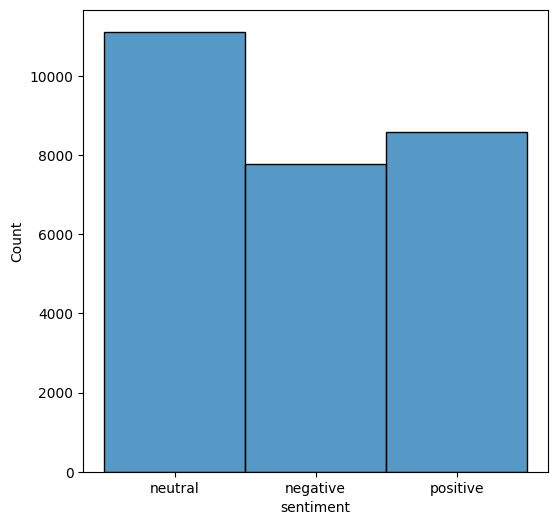

In [14]:
plt.figure(figsize=(6,6))
sns.histplot(data=train,x='sentiment')

In [15]:
temp = train.groupby('sentiment').count()['text'].reset_index().sort_values(by= 'text',ascending= False)

In [16]:
temp

,sentiment,text
1,neutral,11117
2,positive,8582
0,negative,7781


In [17]:
fig = go.Figure(go.Funnelarea(
    text =temp.sentiment,
    values = temp.text,
    title = {"position": "top center", "text": "Funnel-Chart of Sentiment Distribution"}
    ))
fig.show()

### Generating Meta Features 

In [18]:
def jaccard(str1, str2):
    a = set(str1.lower().split())
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c))/(len(a)+len(b)-len(c))

In [19]:
results_jaccard=[]
for ind,row in train.iterrows():
    sentence1= row.text
    sentence2= row.selected_text
    
    jaccard_score = jaccard(sentence1,sentence2)
    results_jaccard.append([sentence1,sentence2,jaccard_score])

In [20]:
jaccard = pd.DataFrame(results_jaccard,columns = ["text", "selected_text", "jaccard_score"])
train = train.merge(jaccard, how='outer')        
        
    

In [21]:
train.head()

,textID,text,selected_text,sentiment,jaccard_score
0,0fab80d6b2,\tREALLY?? oh.. sorry yall lol,sorry,negative,0.200000
1,8106d4c6fa,_beckett Thanks so much !,beckett Thanks,positive,0.166667
2,3792c7b13e,You`ll be missed!! Bring me back a key...,You`ll be miss,negative,0.222222
3,b58a92fe10,get lit I am http://bit.ly/OASQR,get lit I am http://bit.ly/,neutral,0.666667
4,18180bb2ec,Good morning to you ! Its so pretty outs...,Its so pr,positive,0.181818


In [22]:
train['Num_words_ST'] = train['selected_text'].apply(lambda x: len(str(x).split())) #no of words in selected text
train['Num_word_text'] = train['text'].apply(lambda x: len(str(x).split())) #no of words in main text
train['difference_in_words'] = train['Num_word_text'] - train['Num_words_ST']

In [23]:
train.head()

,textID,text,selected_text,sentiment,jaccard_score,Num_words_ST,Num_word_text,difference_in_words
0,0fab80d6b2,\tREALLY?? oh.. sorry yall lol,sorry,negative,0.200000,1,5,4
1,8106d4c6fa,_beckett Thanks so much !,beckett Thanks,positive,0.166667,2,5,3
2,3792c7b13e,You`ll be missed!! Bring me back a key...,You`ll be miss,negative,0.222222,3,8,5
3,b58a92fe10,get lit I am http://bit.ly/OASQR,get lit I am http://bit.ly/,neutral,0.666667,5,5,0
4,18180bb2ec,Good morning to you ! Its so pretty outs...,Its so pr,positive,0.181818,3,10,7


In [24]:
hist_data = [train['Num_words_ST'],train['Num_word_text']]

group_labels = ['Selected_Text', 'Text']

# Create distplot with custom bin_size
fig = ff.create_distplot(hist_data, group_labels,show_curve=True)
fig.update_layout(title_text='Distribution of Number Of words')
fig.update_layout(
    autosize=False,
    width=900,
    height=700,
    paper_bgcolor="LightSteelBlue",
)
fig.show()

/tmp/ipykernel_18/2469916015.py:1: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/tmp/ipykernel_18/2469916015.py:2: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



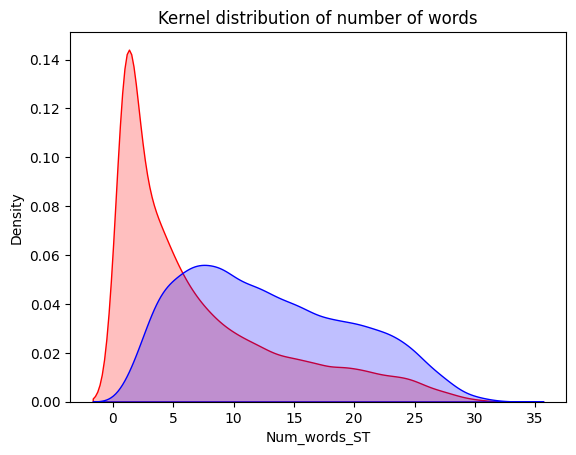

In [25]:
p1 = sns.kdeplot(train['Num_words_ST'],shade = True,color= "r").set_title('Kernel distribution of number of words')
p1 = sns.kdeplot(train['Num_word_text'],shade = True, color = "b")


/tmp/ipykernel_18/1218442226.py:1: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/tmp/ipykernel_18/1218442226.py:2: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



Text(0.5, 1.0, 'KDE PLOt ')

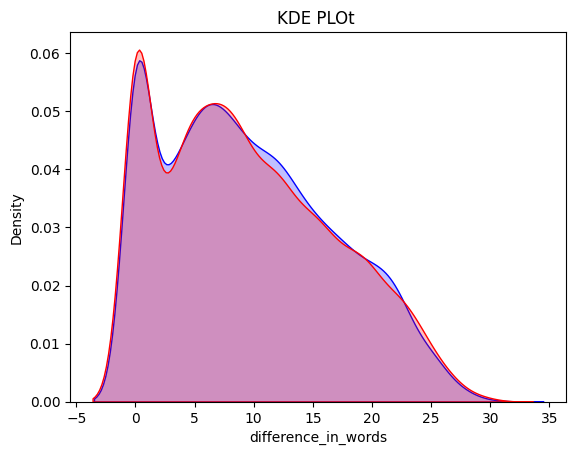

In [26]:
sns.kdeplot(train[train['sentiment'] == 'positive']['difference_in_words'],shade = True, color= "b").set_title("KDE PLOt ")
sns.kdeplot(train[train['sentiment'] == 'negative']['difference_in_words'],shade = True, color= "r").set_title("KDE PLOt ")

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



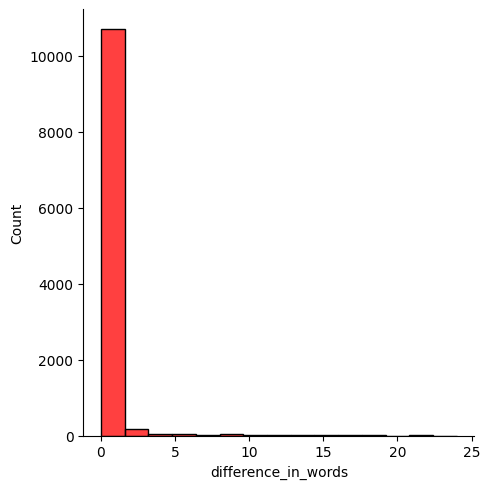

In [27]:
sns.displot(train[train['sentiment'] == 'neutral']['difference_in_words'], color= "r",kde=False)

I was not able to plot kde plot for neutral tweets because most of the values for difference in number of words were zero. We can see it clearly now ,if we had used the feature in the starting we would have known that text and selected text are mostly the same for neutral tweets,thus its always important to keep the end goal in mind while performing EDA

/tmp/ipykernel_18/309696003.py:1: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/tmp/ipykernel_18/309696003.py:2: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



Text(0.5, 1.0, 'KDE PLOt ')

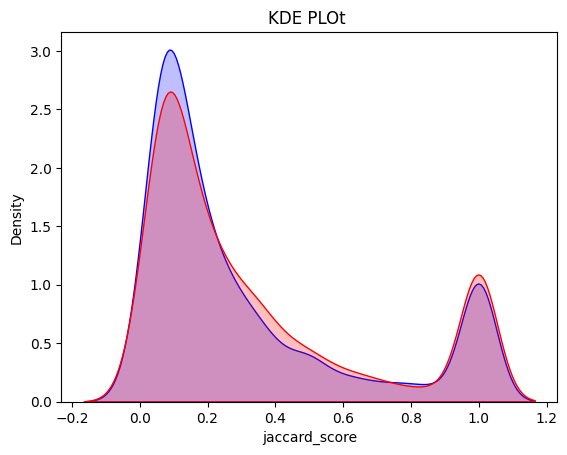

In [28]:
sns.kdeplot(train[train['sentiment'] == 'positive']['jaccard_score'],shade = True, color= "b").set_title("KDE PLOt ")
sns.kdeplot(train[train['sentiment'] == 'negative']['jaccard_score'],shade = True, color= "r").set_title("KDE PLOt ")
#sns.kdeplot(train[train['sentiment'] == 'neutral']['jaccard_score'],shade = True, color= "r").set_title("KDE PLOt ") 

/tmp/ipykernel_18/884338615.py:1: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



<Axes: xlabel='jaccard_score', ylabel='Density'>

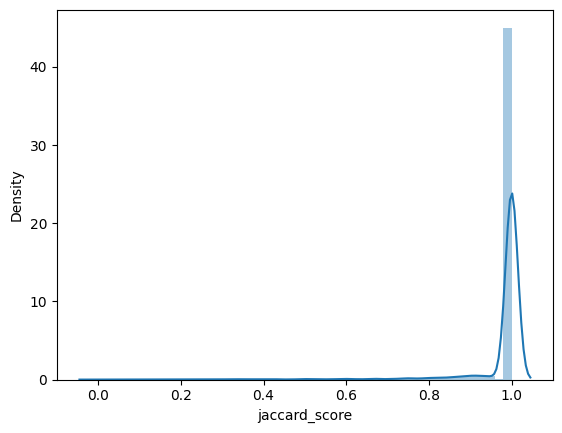

In [29]:
sns.distplot(train[train['sentiment']=='neutral']['jaccard_score'])

We can see some interesting trends here:

* Positive and negative tweets have high kurtosis and thus values are concentrated in two regions narrow and high density

* Neutral tweets have a low kurtosis value and their is bump in density near values of 1

For those who don't know :

* Kurtosis is the measure of how peaked a distribution is and how much spread it is around that peak

* Skewness measures how much a curve deviates from a normal distribution

**Conclusion Of EDA**

We can see from the jaccard score plot that there is peak for negative and positive plot around score of 1 .That means there is a cluster of tweets where there is a high similarity between text and selected texts ,if we can find those clusters then we can predict text for selected texts for those tweets irrespective of segment
Let's see if we can find those clusters,one interesting idea would be to check tweets which have number of words lesss than 3 in text, because there the text might be completely used as text

In [30]:
train.head()

,textID,text,selected_text,sentiment,jaccard_score,Num_words_ST,Num_word_text,difference_in_words
0,0fab80d6b2,\tREALLY?? oh.. sorry yall lol,sorry,negative,0.200000,1,5,4
1,8106d4c6fa,_beckett Thanks so much !,beckett Thanks,positive,0.166667,2,5,3
2,3792c7b13e,You`ll be missed!! Bring me back a key...,You`ll be miss,negative,0.222222,3,8,5
3,b58a92fe10,get lit I am http://bit.ly/OASQR,get lit I am http://bit.ly/,neutral,0.666667,5,5,0
4,18180bb2ec,Good morning to you ! Its so pretty outs...,Its so pr,positive,0.181818,3,10,7


In [31]:
k = train[train['Num_word_text']<=2]

In [32]:
type(k)

pandas.core.frame.DataFrame

In [33]:
k.groupby('sentiment')['jaccard_score'].mean()

sentiment
negative    0.788580
neutral     0.977805
positive    0.765700
Name: jaccard_score, dtype: float64

In [34]:
#We can see that there is similarity between text and selected text .Let's have closer look

In [35]:
k[k['sentiment']=='positive']

,textID,text,selected_text,sentiment,jaccard_score,Num_words_ST,Num_word_text,difference_in_words
100,3ff9947935,**** right!,**** right!,positive,1.0,2,2,0
151,d2f915b8c7,Good Morning!,Good,positive,0.5,1,2,1
154,b4fa2d20e4,Good one,Good one,positive,1.0,2,2,0
155,5714d8c2c3,Goodnight.,Goodnight,positive,0.0,1,1,0
334,6d9bd35d32,Thank you,Thank,positive,0.5,1,2,1
...,...,...,...,...,...,...,...,...
26454,0ccac3f8b7,sweet situations.,sweet situations.,positive,1.0,2,2,0
26484,6475ddf649,thanks,thanks,positive,1.0,1,1,0
26499,274181e2e2,thanx,thanx,positive,1.0,1,1,0
26933,28fc81d56a,wants cookie,wants cookie,positive,1.0,2,2,0


Thus its clear that most of the times , text is used as selected text.We can improve this by preprocessing the text which have word length less than 3.We will remember this information and use it in model building

**Cleaning the corpus**

In [36]:
train.head()

,textID,text,selected_text,sentiment,jaccard_score,Num_words_ST,Num_word_text,difference_in_words
0,0fab80d6b2,\tREALLY?? oh.. sorry yall lol,sorry,negative,0.200000,1,5,4
1,8106d4c6fa,_beckett Thanks so much !,beckett Thanks,positive,0.166667,2,5,3
2,3792c7b13e,You`ll be missed!! Bring me back a key...,You`ll be miss,negative,0.222222,3,8,5
3,b58a92fe10,get lit I am http://bit.ly/OASQR,get lit I am http://bit.ly/,neutral,0.666667,5,5,0
4,18180bb2ec,Good morning to you ! Its so pretty outs...,Its so pr,positive,0.181818,3,10,7


In [37]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub('https?://\S+|www\.\S+','',text)
    text = re.sub('\[.*?\]','',text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('\n', '', text)
    
    return text

In [38]:
train['text'] = train['text'].apply(lambda x: clean_text(x))
train['selected_text'] = train['selected_text'].apply(lambda x: clean_text(x))

In [39]:
train.head()

,textID,text,selected_text,sentiment,jaccard_score,Num_words_ST,Num_word_text,difference_in_words
0,0fab80d6b2,\treally oh sorry yall lol,sorry,negative,0.200000,1,5,4
1,8106d4c6fa,beckett thanks so much,beckett thanks,positive,0.166667,2,5,3
2,3792c7b13e,youll be missed bring me back a keychain,youll be miss,negative,0.222222,3,8,5
3,b58a92fe10,get lit i am,get lit i am,neutral,0.666667,5,5,0
4,18180bb2ec,good morning to you its so pretty outsi...,its so pr,positive,0.181818,3,10,7


**Most common words in our target-selected text**

In [40]:
train['temp_list'] = train['selected_text'].apply(lambda x: str(x).split())
top = Counter([item for sublist in train['temp_list'] for item in sublist])

temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']


In [41]:
temp

,Common_words,count
0,i,7200
1,to,5306
2,the,4590
3,a,3538
4,my,2783
5,you,2624
6,and,2321
7,it,2158
8,is,2115
9,in,1986


In [42]:
fig = px.bar(temp, x="count", y="Common_words", title='Commmon Words in Selected Text', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

/opt/conda/lib/python3.10/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



#Remove Stop words

In [43]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [44]:
train.head()

,textID,text,selected_text,sentiment,jaccard_score,Num_words_ST,Num_word_text,difference_in_words,temp_list
0,0fab80d6b2,\treally oh sorry yall lol,sorry,negative,0.200000,1,5,4,[sorry]
1,8106d4c6fa,beckett thanks so much,beckett thanks,positive,0.166667,2,5,3,"[beckett, thanks]"
2,3792c7b13e,youll be missed bring me back a keychain,youll be miss,negative,0.222222,3,8,5,"[youll, be, miss]"
3,b58a92fe10,get lit i am,get lit i am,neutral,0.666667,5,5,0,"[get, lit, i, am]"
4,18180bb2ec,good morning to you its so pretty outsi...,its so pr,positive,0.181818,3,10,7,"[its, so, pr]"


In [45]:
def remove_stopwords(text):
    return [words for words in text if words not in set(stopwords.words('english'))] 
train['temp_list'] = train['temp_list'].apply(lambda text:remove_stopwords(text))


In [46]:
top = Counter([item for sublist in train['temp_list'] for item in sublist])

temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp

temp = temp[temp['Common_words']!='im']

In [47]:
temp

,Common_words,count
1,good,1251
2,day,1058
3,love,909
4,happy,852
5,like,774
6,get,772
7,dont,765
8,go,700
9,cant,613
10,work,612


In [48]:
fig = px.treemap(temp, path=['Common_words'], values='count',title='Tree of Most Common Words')
fig.show()

**Most common words in our target-selected text**

In [49]:
train['text_temp_list'] = train['text'].apply(lambda x: str(x).split())
train['text_temp_list'] = train['text_temp_list'].apply(lambda text:remove_stopwords(text))
top = Counter([item for sublist in train['text_temp_list'] for item in sublist])

temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp

,Common_words,count
0,im,3020
1,day,2044
2,good,1549
3,get,1426
4,like,1346
5,go,1267
6,dont,1200
7,love,1122
8,work,1112
9,today,1096


In [50]:
temp = temp[temp['Common_words']!='im']

In [51]:
fig = px.bar(temp, x="count", y="Common_words", title='Commmon Words in Text', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

/opt/conda/lib/python3.10/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



## Most common words Sentiments Wise

Let's look at the most common words in different sentiments

In [52]:
Positive_sent = train[train['sentiment']=='positive']
Negative_sent = train[train['sentiment']=='negative']
Neutral_sent = train[train['sentiment']=='neutral']

In [53]:
Positive_sent

,textID,text,selected_text,sentiment,jaccard_score,Num_words_ST,Num_word_text,difference_in_words,temp_list,text_temp_list
1,8106d4c6fa,beckett thanks so much,beckett thanks,positive,0.166667,2,5,3,"[beckett, thanks]","[beckett, thanks, much]"
4,18180bb2ec,good morning to you its so pretty outsi...,its so pr,positive,0.181818,3,10,7,[pr],"[good, morning, pretty, outside, today]"
5,a088ac278e,i love you guys get your to australia in...,i lo,positive,0.066667,2,14,12,[lo],"[love, guys, get, australia, december, birthday]"
8,eae9c20c8d,followfriday thank you so much im so behin...,day thank you so mu,positive,0.176471,5,16,11,"[day, thank, mu]","[followfriday, thank, much, im, behind, still,..."
9,a650b02d11,overwhelming lead for strawberry lemonade...,overwhelmi,positive,0.076923,2,13,11,[overwhelmi],"[overwhelming, lead, strawberry, lemonade, hus..."
...,...,...,...,...,...,...,...,...,...,...
27468,903a912442,your saaaaafe with epic times again last nig...,good way to kick off this month,positive,0.318182,7,22,15,"[good, way, kick, month]","[saaaaafe, epic, times, last, night, old, frie..."
27471,1484dd2416,yum mothers day lunch at the food business in...,delicious such a gorgeous day,positive,0.312500,5,17,12,"[delicious, gorgeous, day]","[yum, mothers, day, lunch, food, business, bur..."
27472,42c51af9ad,yummy chocolate cakewish even i got one for my...,yummy chocolate cakewish even i got one for my...,positive,0.833333,10,12,2,"[yummy, chocolate, cakewish, even, got, one, b...","[yummy, chocolate, cakewish, even, got, one, b..."
27476,79a3f22848,cont that right their is why fake btches shoul...,excite me,positive,0.105263,2,21,19,[excite],"[cont, right, fake, btches, shouldnt, mess, re..."


In [54]:

Positive_sent['text_temp_list'] = Positive_sent['text_temp_list'].apply(lambda text:remove_stopwords(text))
top = Counter([item for sublist in Positive_sent['text_temp_list'] for item in sublist])

temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']

temp = temp[temp['Common_words']!='im']
temp

,Common_words,count
0,day,1223
1,good,1046
2,love,875
3,happy,840
5,mothers,627
6,thanks,553
7,great,478
8,like,413
9,hope,396
10,get,367


In [55]:
fig = px.bar(temp, x="count", y="Common_words", title='Positive Commmon Words in Text', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

/opt/conda/lib/python3.10/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



In [56]:
Positive_sent['temp_list'] = Positive_sent['temp_list'].apply(lambda text:remove_stopwords(text))
top = Counter([item for sublist in Positive_sent['temp_list'] for item in sublist])

temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']

temp = temp[temp['Common_words']!='im']
temp

,Common_words,count
0,good,826
1,happy,730
2,love,697
3,day,456
4,thanks,439
5,great,364
6,fun,287
7,nice,267
8,mothers,259
9,hope,245


In [57]:
#Negative_sent['temp_list'] = Negative_sent['temp_list'].apply(lambda text:remove_stopwords(text))
top = Counter([item for sublist in Negative_sent['temp_list'] for item in sublist])

temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']

temp = temp[temp['Common_words']!='im']
temp

,Common_words,count
1,miss,358
2,sad,343
3,sorry,300
4,bad,246
5,hate,230
6,dont,221
7,cant,201
8,sick,166
9,like,162
10,sucks,159


In [58]:
fig = px.treemap(temp, path=['Common_words'], values='count',title='Tree of Most Common Negative Sentiment Words')
fig.show()

In [59]:
#Negative_sent['temp_list'] = Negative_sent['temp_list'].apply(lambda text:remove_stopwords(text))
top = Counter([item for sublist in Neutral_sent['temp_list'] for item in sublist])

temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']

temp = temp[temp['Common_words']!='im']
temp

,Common_words,count
1,get,612
2,go,569
3,day,492
4,dont,482
5,going,472
6,work,467
7,like,445
8,got,441
9,today,427
10,lol,427


In [60]:
fig = px.bar(temp, x="count", y="Common_words", title='Most Commmon Neutral Words in Text', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

/opt/conda/lib/python3.10/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



We can see words like get,go,dont,got,u,cant,lol,like are common in all three segments . That's interesting because words like dont and cant are more of negative nature and words like lol are more of positive nature.Does this mean our data is incorrectly labelled , we will have more insights on this after N-gram analysis

It will be interesting to see the unique words in different sentiments

Let's Look at Unique Words in each Segment

We will look at unique words in each segment in the Following Order:

Positive
Negative
Neutral

In [61]:
Positive_sent['text_temp_list']

1                                  [beckett, thanks, much]
4                  [good, morning, pretty, outside, today]
5         [love, guys, get, australia, december, birthday]
8        [followfriday, thank, much, im, behind, still,...
9        [overwhelming, lead, strawberry, lemonade, hus...
                               ...                        
27468    [saaaaafe, epic, times, last, night, old, frie...
27471    [yum, mothers, day, lunch, food, business, bur...
27472    [yummy, chocolate, cakewish, even, got, one, b...
27476    [cont, right, fake, btches, shouldnt, mess, re...
27477      [happy, star, wars, dayevery, one, may, fourth]
Name: text_temp_list, Length: 8582, dtype: object

In [62]:
unique_words=[]
for text in Positive_sent['text_temp_list']:
    for word in text:
        if word not in unique_words:
            unique_words.append(word)
        
    

In [63]:
len(list(set(unique_words)))

11912

In [64]:
raw_text = [word for word_list in train['text_temp_list'] for word in word_list]

In [65]:
def words_unique(sentiment,numwords,raw_words):
    allother= []
    for item in train[train.sentiment != sentiment]['text_temp_list']:
        for word in item:
            if word not in allother:
                allother.append(word)
    allother = list(set(allother))
    
    specificonly=[x for x in raw_text if x not in allother]
    
    mycounter = Counter()
    
    for item in train[train.sentiment == sentiment]['text_temp_list']:
        for word in item:
            mycounter[word] += 1
    keep = list(specificonly)
    
    for word in list(mycounter):
        if word not in keep:
            del mycounter[word]
    
    Unique_words = pd.DataFrame(mycounter.most_common(numwords), columns = ['words','count'])
    
    return Unique_words
    
    

In [66]:
Unique_Positive= words_unique('positive', 20, raw_text)
print("The top 20 unique words in Positive Tweets are:")
Unique_Positive.style.background_gradient(cmap='Greens')

The top 20 unique words in Positive Tweets are:


,words,count
0,congratulations,29
1,thnx,10
2,appreciated,8
3,greetings,7
4,shared,7
5,presents,7
6,blessings,6
7,mothersday,6
8,honored,6
9,goood,6


In [67]:
fig = px.treemap(Unique_Positive, path=['words'], values='count',title='Tree Of Unique Positive Words')
fig.show()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 8.6 MB/s eta 0:00:00


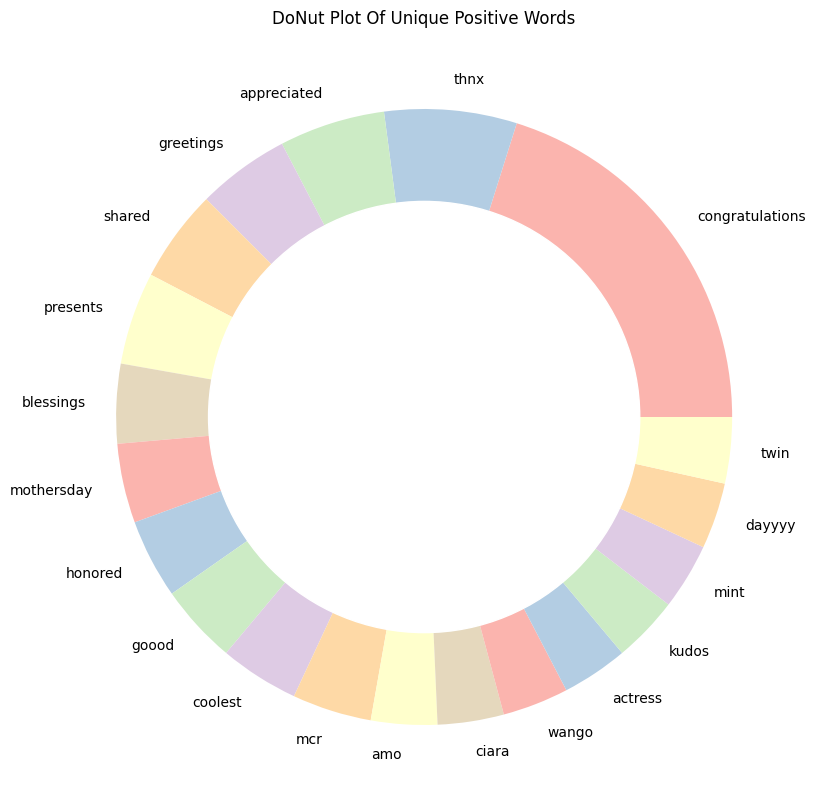

In [68]:
!pip install palettable
from palettable.colorbrewer.qualitative import Pastel1_7
plt.figure(figsize=(16,10))
my_circle=plt.Circle((0,0), 0.7, color='white')
plt.pie(Unique_Positive['count'], labels=Unique_Positive.words, colors=Pastel1_7.hex_colors)
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('DoNut Plot Of Unique Positive Words')
plt.show()

In [69]:
Unique_Negative= words_unique('negative', 20, raw_text)
print("The top 20 unique words in Negative Tweets are:")
Unique_Negative.style.background_gradient(cmap='Greens')

The top 20 unique words in Negative Tweets are:


,words,count
0,ache,12
1,suffering,9
2,saddest,7
3,allergic,7
4,pissing,7
5,cramps,7
6,dealing,6
7,noes,6
8,sob,6
9,devastated,6


In [70]:
Unique_Neutral= words_unique('neutral', 10, raw_text)
print("The top 10 unique words in Neutral Tweets are:")
Unique_Neutral.style.background_gradient(cmap='Oranges')

The top 10 unique words in Neutral Tweets are:


,words,count
0,settings,9
1,explain,7
2,hiya,6
3,mite,6
4,pr,5
5,guessed,5
6,reader,5
7,pfft,5
8,fathers,5
9,bucks,5


By Looking at the Unique Words of each sentiment,we now have much more clarity about the data,these unique words are very strong determiners of Sentiment of tweets

It's Time For WordClouds

We will be building wordclouds in the following order:

WordCloud of Neutral Tweets

WordCloud of Positive Tweets

WordCloud of Negative Tweets

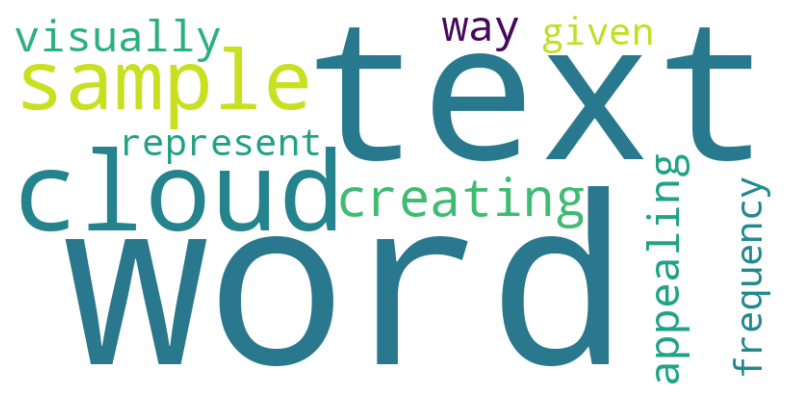

In [71]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Sample text for demonstration
text = "This is a sample text for creating a word cloud. Word clouds are a visually appealing way to represent the frequency of words in a given text."

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the generated word cloud using Matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis labels
plt.show()


In [72]:
def plot_wordcloud(text, mask = None,  max_words=200, max_font_size=100, figure_size=(24.0,16.0), color = 'white',title = None,title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'u','im'}
    stopwords = stopwords.union(more_stopwords)
    
    wordcloud = WordCloud(
    max_words=max_words,
    stopwords=stopwords,
    random_state=42,
    max_font_size=max_font_size,
    mask = mask,
    width=400, 
    height=200)
    
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  


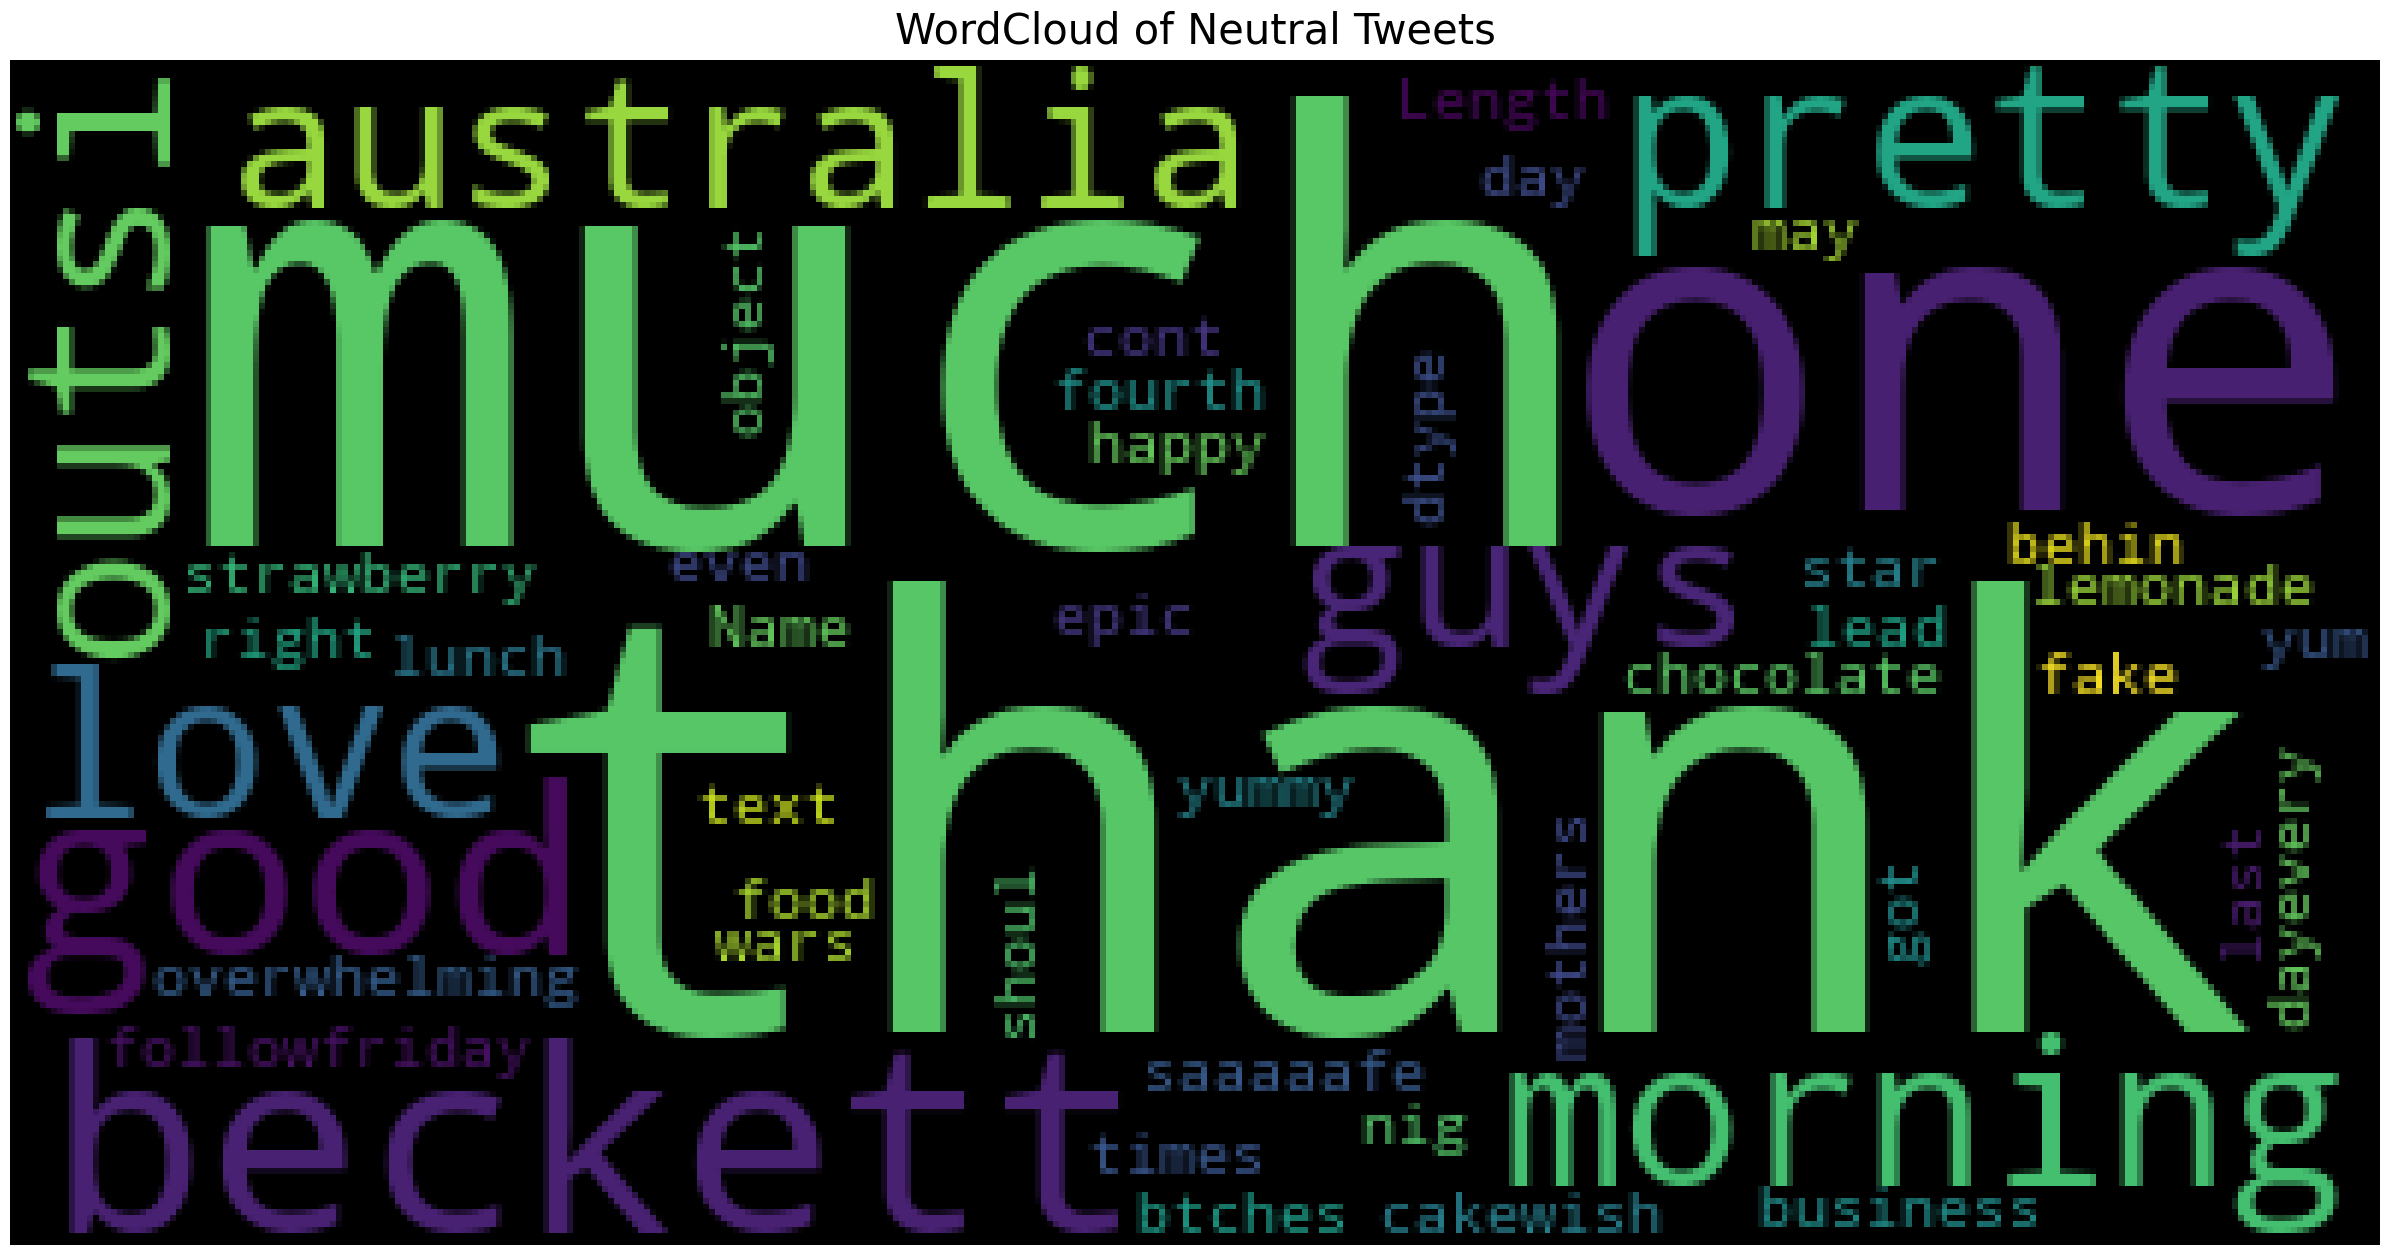

In [73]:

#pos_mask = np.array(Image.open(d+ 'twitter_mask.png'))
plot_wordcloud(Positive_sent.text,mask=None,color='white',max_font_size=100,title_size=30,title="WordCloud of Neutral Tweets")

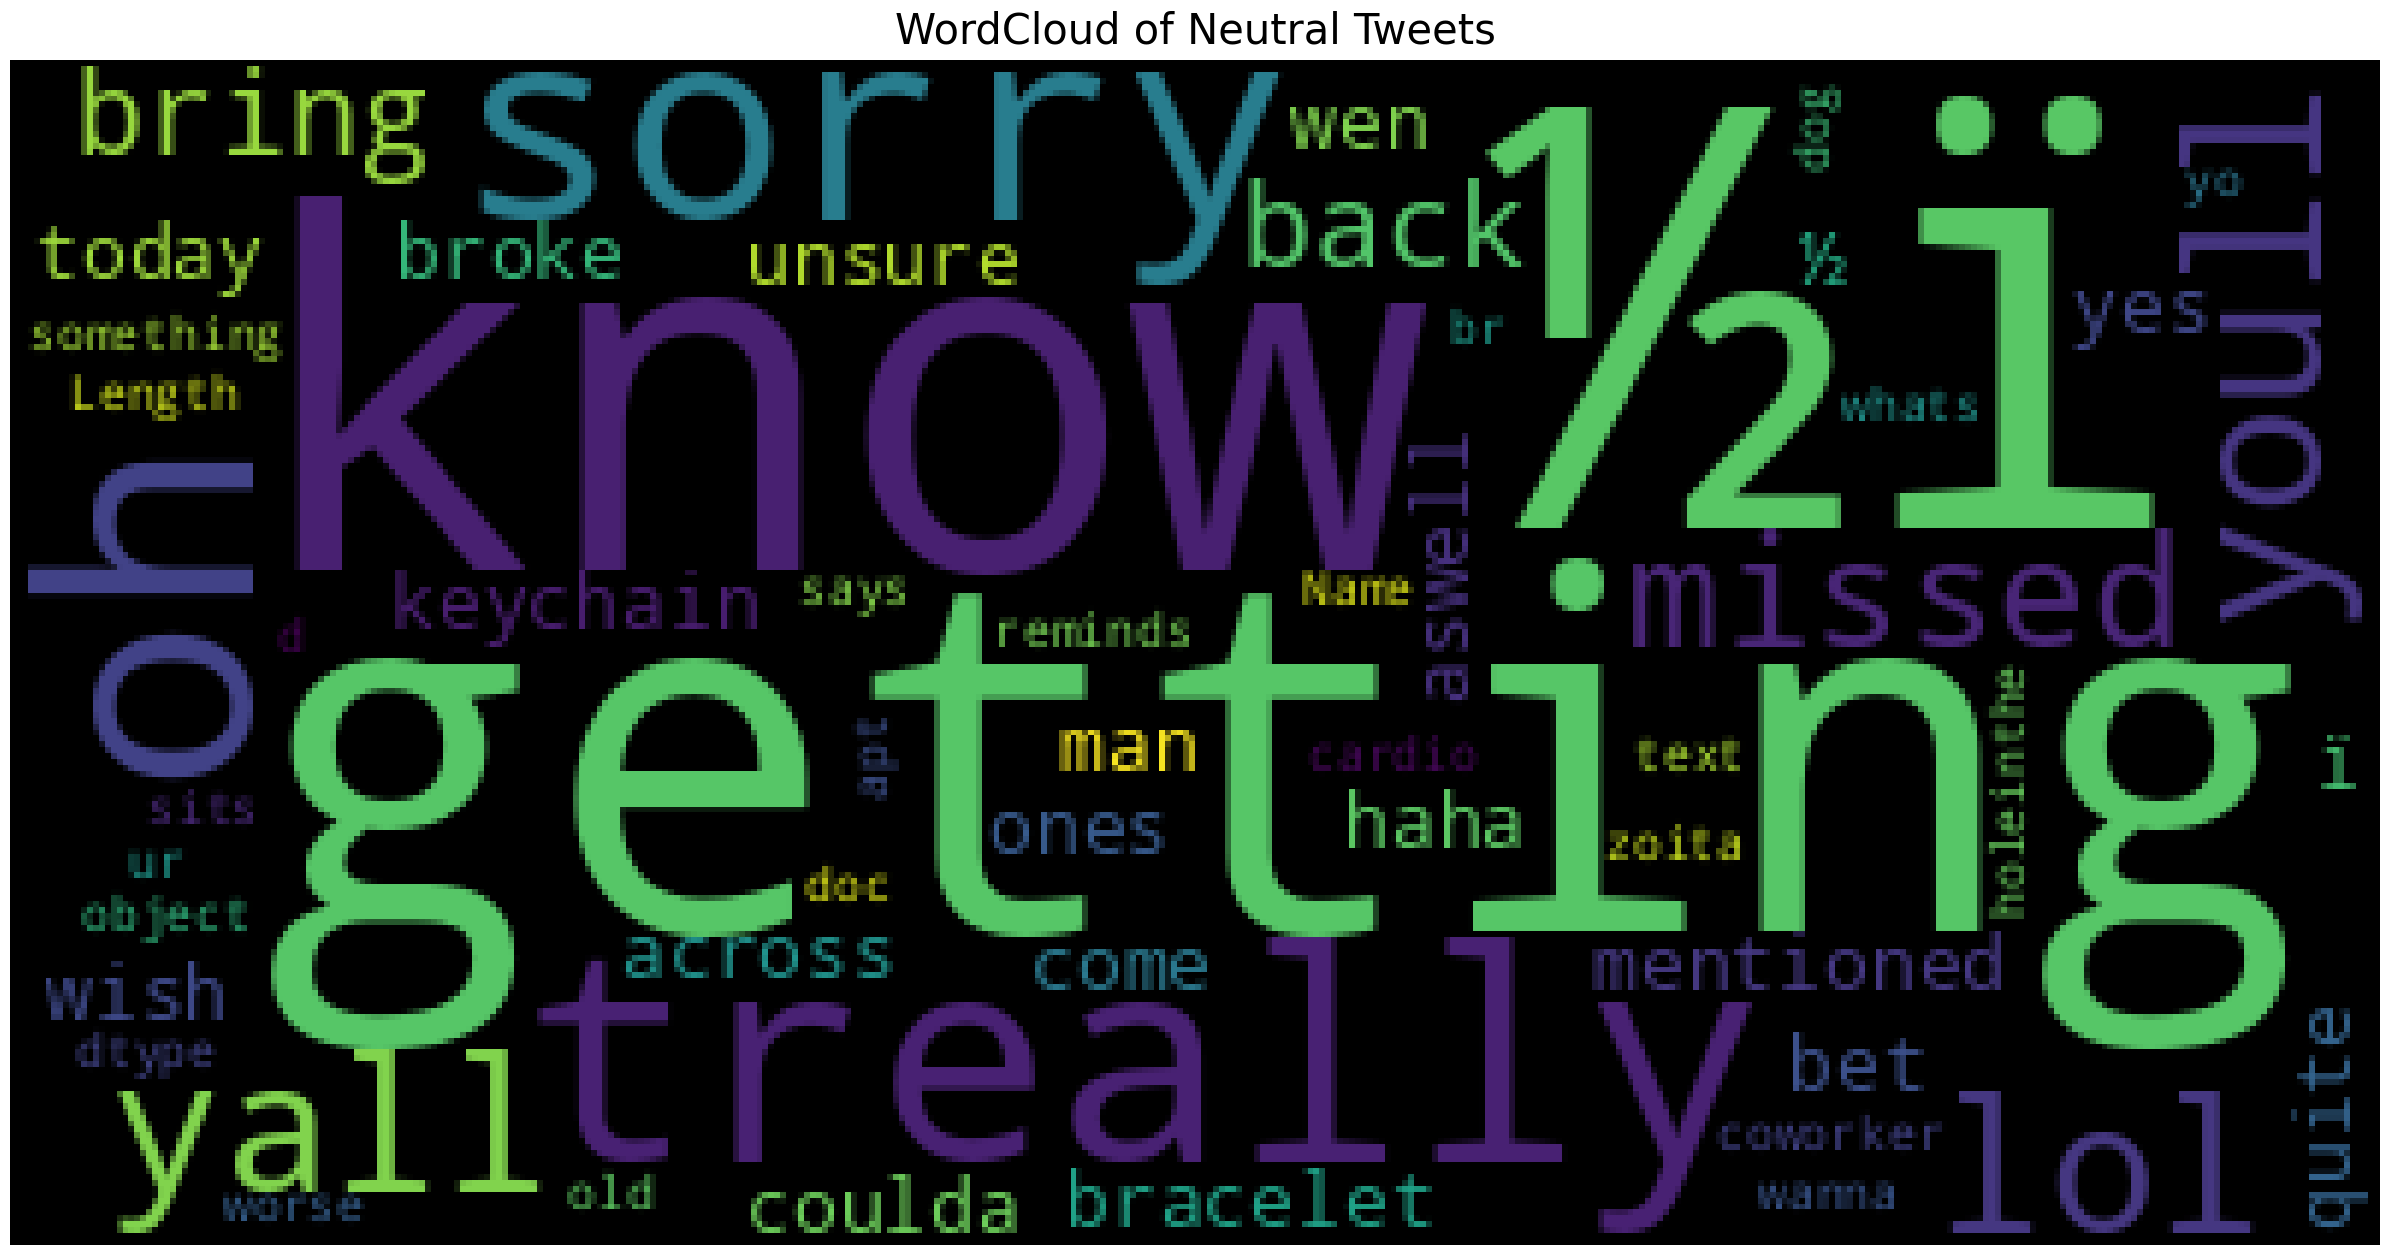

In [74]:
plot_wordcloud(Negative_sent.text,mask=None,color='white',max_font_size=100,title_size=30,title="WordCloud of Neutral Tweets")

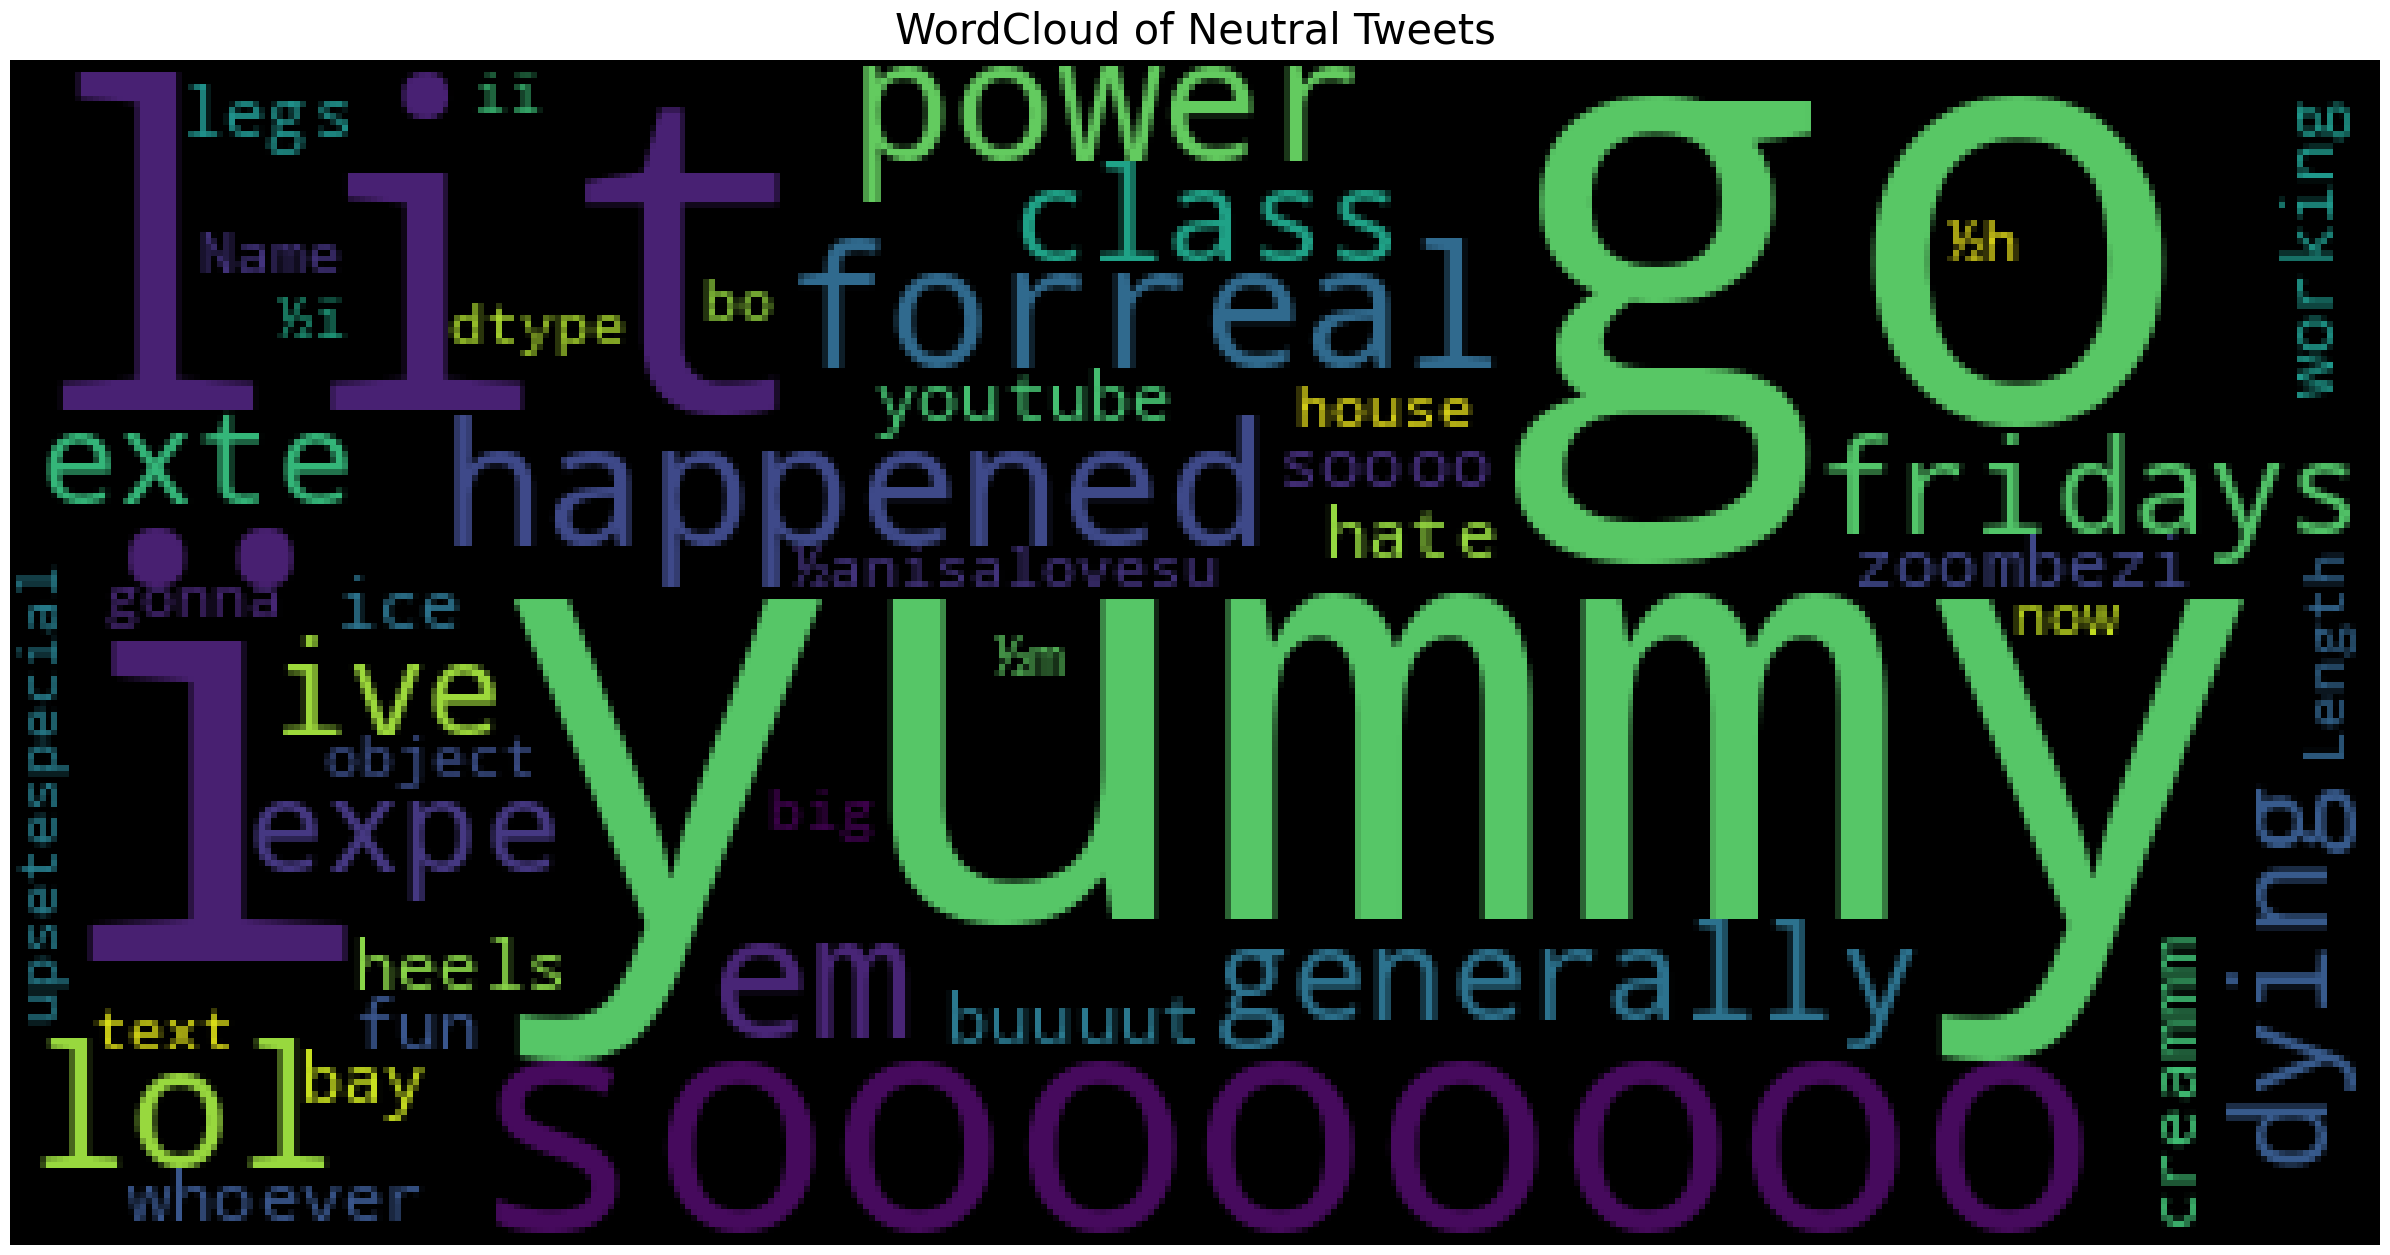

In [75]:
plot_wordcloud(Neutral_sent.text,mask=None,color='white',max_font_size=100,title_size=30,title="WordCloud of Neutral Tweets")

# Modelling

* Named Entity Recognition
* Q&A Problem

I also found a simple approach shared by Nick in his beautiful kernel where he has the concept of Gini Impurity to give weights to words present in tweets and then predicting using the weight of those words : https://www.kaggle.com/nkoprowicz/a-simple-solution-using-only-word-counts/notebook .

Do check it out.
Other Modelling Ideas :- https://www.kaggle.com/c/tweet-sentiment-extraction/discussion/139803 --> Here is a very Nice Idea
Another useful Idea :- https://www.kaggle.com/c/tweet-sentiment-extraction/discussion/139335

### 1)Modelling the Problem as NER

Named Entity Recognition (NER) is a standard NLP problem which involves spotting named entities (people, places, organizations etc.) from a chunk of text, and classifying them into a predefined set of categories
We will be using spacy for creating our own customised NER model or models (seperate for each Sentiment).

* I will use text as selected_text for all neutral tweets due to their high jaccard similarity
* Also I will use text as selected_text for all tweets having number of words less than 3 in text as explained before
* I will train two different models for Positive and Negtive tweets
* I will not preprocess the data because the selected text contains raw text

In [76]:
df_train = pd.read_csv('/kaggle/input/tweet-sentiment-extraction/train.csv')
df_test = pd.read_csv('/kaggle/input/tweet-sentiment-extraction/test.csv')
df_submission = pd.read_csv('/kaggle/input/tweet-sentiment-extraction/sample_submission.csv')

In [77]:
df_train['Num_words_text'] = df_train['text'].apply(lambda x : len(str(x).split())) #Number of words in main text

In [78]:
df_train = df_train[df_train['Num_words_text']>=3]

In [79]:
def save_model(output_dir, nlp, new_model_name):
    ''' This Function Saves model to 
    given output directory'''
    
    output_dir = f'../working/{output_dir}'
    if output_dir is not None:        
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        nlp.meta["name"] = new_model_name
        nlp.to_disk(output_dir)
        print("Saved model to", output_dir)

In [80]:
# pass model = nlp if you want to train on top of existing model 

def train(train_data,output_dir,n_iter = 20,model = None):
    if model is not None:
        nlp = spacy.load(output_dir) #loading existing model
        print("Loaded model '%s'" % model)
    else:
        nlp = spacy.blank('en') # create blank Language class
        print("created a blank 'en' model")
    
    # create the built-in pipeline components and add them to the pipeline
    # nlp.create_pipe works for built-ins that are registered with spaCy
    
    if "ner" not in nlp.pipe_names:
        ner = nlp.create_pipe("ner")
        nlp.add_pipe("ner",last = True)
        #otherwose get it so we can add labels
    else:
        ner = nlp.get_pipe("ner")
        
    #add labels
    for _, annotations in train_data:
        for ent in annotations.get("entities"):
            ner.add_label(ent[2])
            
    #get names of other pipes to disable them during training
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe!= "ner"]
    with nlp.disable_pipes(*other_pipes): #only train NER
        #batch up the examples using spacy's minibatch
        if model is None:
            nlp.begin_training()
        else:
            nlp.resume_training()
            
        for itn in tqdm(range(n_iter)):
            random.shuffle(train_data)
            batches = minibatch(train_data, size = compounding(4.0,500.0,1.001))
            losses = {}
            for batch in batches:
                texts, annotations = zip(*batch)
                
                example = []
                # Update the model with iterating each text
                for i in range(len(texts)):
                    doc = nlp.make_doc(texts[i])
                    example.append(Example.from_dict(doc, annotations[i]))

                # Update the model
                nlp.update(
                    example,
                    drop = 0.5, #dropout- make it harder to memorise data
                    losses = losses
                )
            print("Losses", losses)
    save_model(output_dir, nlp, 'st_ner')

In [81]:
def get_model_out_path(statement):
    model_out_path = None
    if sentiment == 'positive':
        model_out_path = 'models/model_pos'
    elif sentiment == 'negative':
        model_out_path = 'models/model_neg'
    else:
        model_out_path = 'models/model_neu'
    return model_out_path

In [82]:
# creating data on spacy data input format

def get_training_data(sentiment):
    train_data = []
    for index, row in df_train.iterrows():
        if row.sentiment == sentiment:
            selected_text = row.selected_text
            text = row.text
            start = text.find(selected_text)
            end = start + len(selected_text)
            train_data.append((text, {"entities": [[start, end, 'selected_text']]}))
    return train_data

In [83]:
from spacy.training.example import Example

In [84]:
sentiment = 'positive'
train_data = get_training_data(sentiment)
model_path = get_model_out_path(sentiment)

# for demo purpose i am just training the model for 3 iterations, feel free to experiment.
train(train_data, model_path, n_iter=3, model=None)

[2024-02-19 21:22:18,580] [INFO] Created vocabulary
[2024-02-19 21:22:18,582] [INFO] Finished initializing nlp object


created a blank 'en' model


  0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/spacy/training/iob_utils.py:149: UserWarning:

[W030] Some entities could not be aligned in the text "playing with  on a cool new website... hopefully r..." with entities "[[0, 36, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.

/opt/conda/lib/python3.10/site-packages/spacy/training/iob_utils.py:149: UserWarning:

[W030] Some entities could not be aligned in the text "_morley LOL I love your kids" with entities "[[12, 21, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.

/opt/conda/lib/python3.10/site-packages/spacy/training/iob_utils.py:149: UserWarning:

[W030] Some entities could not be aligned in the text "Thankful for last minute doc appointments... Baby

Losses {'ner': 12856.458913699082}


 67%|██████▋   | 2/3 [01:49<00:54, 54.71s/it]

Losses {'ner': 11743.240749205655}


100%|██████████| 3/3 [02:44<00:00, 54.70s/it]

Losses {'ner': 11394.776511229307}
Saved model to ../working/models/model_pos


In [85]:
import warnings
warnings.filterwarnings("ignore")

In [86]:
sentiment = 'negative'

train_data = get_training_data(sentiment)
model_path = get_model_out_path(sentiment)

train(train_data, model_path, n_iter=3, model=None)

[2024-02-19 21:25:05,855] [INFO] Created vocabulary
[2024-02-19 21:25:05,857] [INFO] Finished initializing nlp object


created a blank 'en' model


 33%|███▎      | 1/3 [00:51<01:42, 51.38s/it]

Losses {'ner': 12514.05933491968}


 67%|██████▋   | 2/3 [01:42<00:51, 51.38s/it]

Losses {'ner': 11455.760274195865}


100%|██████████| 3/3 [02:34<00:00, 51.45s/it]

Losses {'ner': 11077.201444788661}
Saved model to ../working/models/model_neg


**Predicting with the trained Model**

In [87]:
def predict_entities(text, model):
    doc = model(text)
    ent_array = []
    for ent in doc.ents:
        start = text.find(ent.text)
        end = start + len(ent.text)
        new_int = [start, end, ent.label_]
        if new_int not in ent_array:
            ent_array.append([start, end, ent.label_])
    selected_text = text[ent_array[0][0]: ent_array[0][1]] if len(ent_array) > 0 else text
    return selected_text

In [88]:
selected_texts = []
MODELS_BASE_PATH = '/kaggle/working/models/'

if MODELS_BASE_PATH is not None:
    print("Loading Models  from ", MODELS_BASE_PATH)
    model_pos = spacy.load(MODELS_BASE_PATH + 'model_pos')
    model_neg = spacy.load(MODELS_BASE_PATH + 'model_neg')
        
    for index, row in df_test.iterrows():
        text = row.text
        output_str = ""
        if row.sentiment == 'neutral' or len(text.split()) <= 2:
            selected_texts.append(text)
        elif row.sentiment == 'positive':
            selected_texts.append(predict_entities(text, model_pos))
        else:
            selected_texts.append(predict_entities(text, model_neg))
        
df_test['selected_text'] = selected_texts

Loading Models  from  /kaggle/working/models/


In [89]:
df_submission['selected_text'] = df_test['selected_text']
df_submission.to_csv("submission.csv", index=False)
display(df_submission.head(10))

,textID,selected_text
0,f87dea47db,Last session of the day http://twitpic.com/67ezh
1,96d74cb729,exciting
2,eee518ae67,"Recession hit Veronique Branquinho, she has to..."
3,01082688c6,happy bday!
4,33987a8ee5,I like
5,726e501993,that`s great!
6,261932614e,I THINK EVERYONE HATES ME ON HERE lol
7,afa11da83f,"soooooo wish i could, but im in school and my..."
8,e64208b4ef,and within a short time of the last clue all ...
9,37bcad24ca,What did you get? My day is alright.. haven`...
